### Import Modules

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
register_matplotlib_converters()

### Generate some data

$y_{t} = 50 + 0.4\epsilon_{t-1} + 0.3\epsilon_{t-2} + \epsilon{t}$

$\epsilon_t \sim \mathcal{N}(0, 1)$


In [31]:
# generate the errors, 400 of them
errors = np.random.normal(0, 1, 400)

In [32]:
# generate 4 months of data -
date_index = pd.date_range(start = '9/1/2019', end = '1/1/2020')

In [33]:
mu = 50
series = []
for t in range(1, len(date_index) + 1):
    series.append(mu + 0.4*errors[t - 1] + 0.3*errors[t - 2] + errors[t])

In [34]:
series = pd.Series(series, date_index)
series[0:3]

2019-09-01    50.067727
2019-09-02    50.965437
2019-09-03    50.805289
Freq: D, dtype: float64

In [35]:
series = series.asfreq(pd.infer_freq(series.index))
series[0:3]

2019-09-01    50.067727
2019-09-02    50.965437
2019-09-03    50.805289
Freq: D, dtype: float64

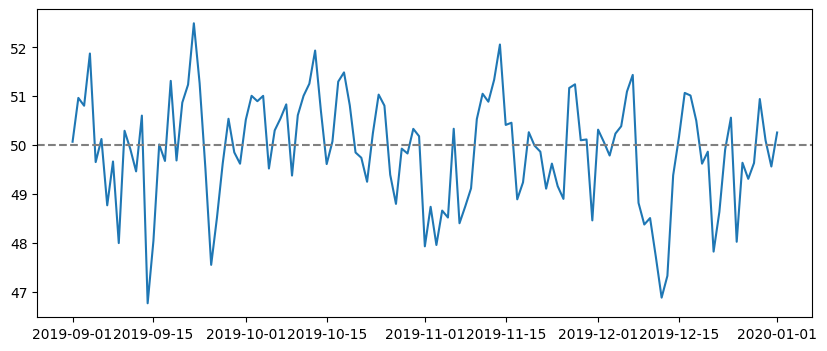

In [36]:
plt.figure(figsize = (10, 4))
plt.plot(series)
plt.axhline(mu, linestyle = '--', color = 'grey')

### ACF

<BarContainer object of 10 artists>

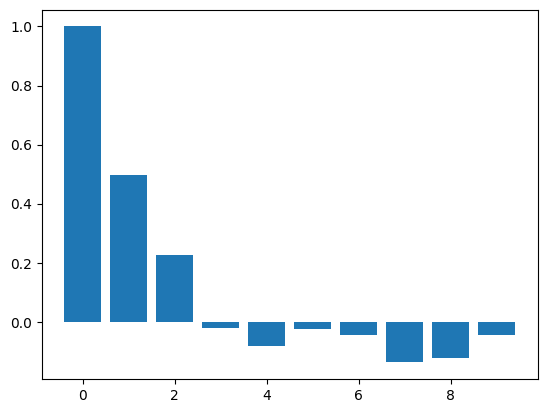

In [37]:
acf_vals = acf(series)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags])

Here lag 1 & 2 are very strong. So, based on this it could be an MA - 2 model

### PACF

<BarContainer object of 10 artists>

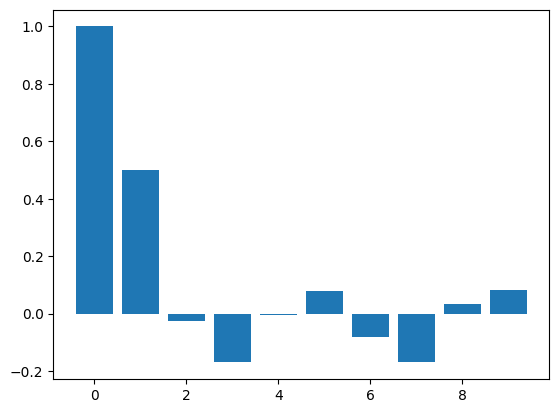

In [38]:
pacf_vals = pacf(series)
num_lags = 10
plt.bar(range(num_lags), pacf_vals[:num_lags])

Here, PACF is alternating and diminishing over time, pointing it to be a moving average process.

### Get training and testing sets -

In [39]:
train_end = datetime(2019, 12, 30)
test_end = datetime(2020, 1, 1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days = 1):test_end]

### Fit ARIMA Model

In [40]:
# create the model
model = ARIMA(train_data, order = (0, 0, 2))

In [41]:
# fit the model
model_fit = model.fit()

In [42]:
# summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -166.892
Date:                Tue, 16 May 2023   AIC                            341.784
Time:                        19:37:39   BIC                            352.967
Sample:                    09-01-2019   HQIC                           346.326
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.8971      0.174    287.315      0.000      49.557      50.237
ma.L1          0.4710      0.091      5.185      0.000       0.293       0.649
ma.L2          0.3296      0.089      3.706      0.0

So, the predicted model is -

$\hat{y_{t}} = 50 + 0.47\epsilon_{t-1} + 0.32\epsilon_{t-2}$

In [43]:
# Get prediction start and end dates

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [44]:
pred_start_date

Timestamp('2019-12-31 00:00:00', freq='D')

In [45]:
pred_end_date

Timestamp('2020-01-01 00:00:00', freq='D')

In [46]:
# Get predictions and residuals-
predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)

In [47]:
residuals = test_data - predictions

In [48]:
residuals

2019-12-31   -0.636476
2020-01-01    0.449567
Freq: D, dtype: float64

In [49]:
test_data

2019-12-31    49.560600
2020-01-01    50.257233
Freq: D, dtype: float64

In [50]:
predictions

2019-12-31    50.197077
2020-01-01    49.807666
Freq: D, Name: predicted_mean, dtype: float64

In [52]:
series

2019-09-01    50.067727
2019-09-02    50.965437
2019-09-03    50.805289
2019-09-04    51.874504
2019-09-05    49.651983
                ...    
2019-12-28    49.632299
2019-12-29    50.942467
2019-12-30    50.095759
2019-12-31    49.560600
2020-01-01    50.257233
Freq: D, Length: 123, dtype: float64

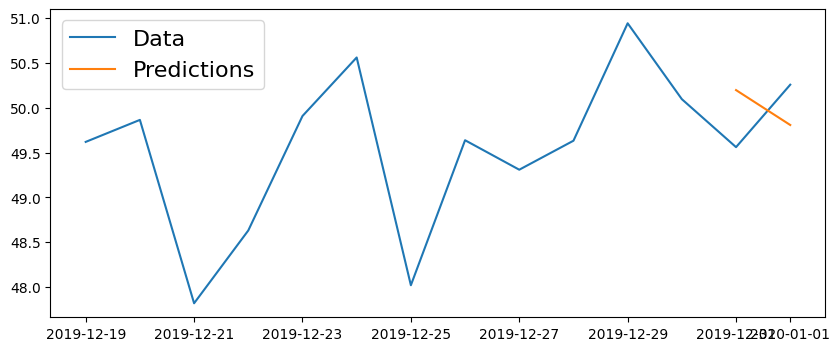

In [51]:
plt.figure(figsize = (10, 4))

plt.plot(series[-14: ])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize = 16)

In [53]:
print('Mean Absolute Percent Error : ', round(np.mean(abs(residuals / test_data)), 4))

Mean Absolute Percent Error :  0.0109


In [54]:
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals ** 2)))

Root Mean Squared Error:  0.5510048116703719
